[Table of Contents](./table_of_contents.ipynb)

# The Extended Kalman Filter

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

We have developed the theory for the linear Kalman filter. Then, in the last two chapters we broached the topic of using Kalman filters for nonlinear problems. In this chapter we will learn the Extended Kalman filter (EKF). The EKF handles nonlinearity by linearizing the system at the point of the current estimate, and then the linear Kalman filter is used to filter this linearized system. It was one of the very first techniques used for nonlinear problems, and it remains the most common technique. 

The EKF provides significant mathematical challenges to the designer of the filter; this is the most challenging chapter of the book. I do everything I can to avoid the EKF in favor of other techniques that have been developed to filter nonlinear problems. However, the topic is unavoidable; all classic papers and a majority of current papers in the field use the EKF. Even if you do not use the EKF in your own work you will need to be familiar with the topic to be able to read the literature. 

## Linearizing the Kalman Filter

The Kalman filter uses linear equations, so it does not work with nonlinear problems. Problems can be nonlinear in two ways. First, the process model might be nonlinear. An object falling through the atmosphere encounters drag which reduces its acceleration. The drag coefficient varies based on the velocity the object. The resulting behavior is nonlinear - it cannot be modeled with linear equations. Second, the measurements could be nonlinear. For example, a radar gives a range and bearing to a target. We use trigonometry, which is nonlinear, to compute the position of the target.

For the linear filter we have these equations for the process and measurement models:

$$\begin{aligned}\dot{\mathbf x} &= \mathbf{Ax} + w_x\\
\mathbf z &= \mathbf{Hx} + w_z
\end{aligned}$$

Where $\mathbf A$ is the systems dynamic matrix. Using the state space methods covered in the **Kalman Filter Math** chapter these equations can be transformed into 
$$\begin{aligned}\bar{\mathbf x} &= \mathbf{Fx} \\
\mathbf z &= \mathbf{Hx}
\end{aligned}$$

where $\mathbf F$ is the *fundamental matrix*. The noise $w_x$ and $w_z$ terms are incorporated into the matrices $\mathbf R$ and $\mathbf Q$. This form of the equations allow us to compute the state at step $k$ given a measurement at step $k$ and the state estimate at step $k-1$. In earlier chapters I built your intuition and minimized the math by using problems describable with Newton's equations. We know how to design $\mathbf F$ based on high school physics.


For the nonlinear model the linear expression $\mathbf{Fx} + \mathbf{Bu}$ is replaced by a nonlinear function $f(\mathbf x, \mathbf u)$, and the linear expression $\mathbf{Hx}$ is replaced by a nonlinear function $h(\mathbf x)$:

$$\begin{aligned}\dot{\mathbf x} &= f(\mathbf x, \mathbf u) + w_x\\
\mathbf z &= h(\mathbf x) + w_z
\end{aligned}$$

You might imagine that we could proceed by finding a new set of Kalman filter equations that optimally solve these equations. But if you remember the charts in the **Nonlinear Filtering** chapter you'll recall that passing a Gaussian through a nonlinear function results in a probability distribution that is no longer Gaussian. So this will not work.

The EKF does not alter the Kalman filter's linear equations. Instead, it *linearizes* the nonlinear equations at the point of the current estimate, and uses this linearization in the linear Kalman filter. 

*Linearize* means what it sounds like. We find a line that most closely matches the curve at a defined point. The graph below linearizes the parabola $f(x)=x^2-2x$ at $x=1.5$.

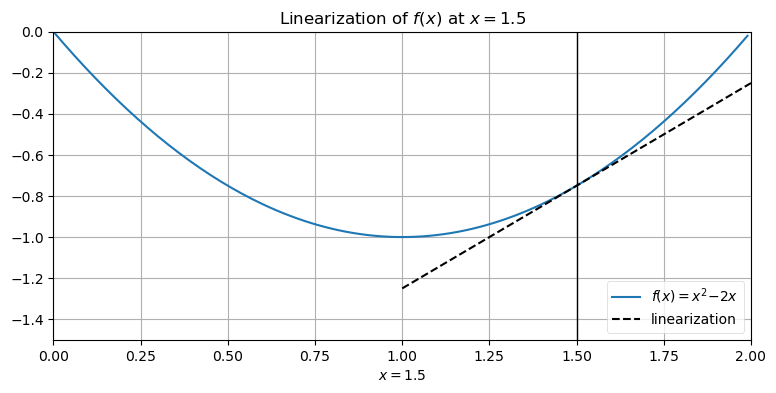

In [3]:
import kf_book.ekf_internal as ekf_internal
ekf_internal.show_linearization()

If the curve above is the process model, then the dotted lines shows the linearization of that curve for the estimate $x=1.5$.

We linearize systems by taking the derivative, which finds the slope of a curve:

$$\begin{aligned}
f(x) &= x^2 -2x \\
\frac{df}{dx} &= 2x - 2
\end{aligned}$$

and then evaluating it at $x$:

$$\begin{aligned}m &= f'(x=1.5) \\&= 2(1.5) - 2 \\&= 1\end{aligned}$$ 

Linearizing systems of differential equations is similar. We linearize $f(\mathbf x, \mathbf u)$, and $h(\mathbf x)$ by taking the partial derivatives of each to evaluate $\mathbf F$ and $\mathbf H$ at the point $\mathbf x_t$ and $\mathbf u_t$. We call the partial derivative of a matrix the [*Jacobian*](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant). This gives us the the discrete state transition matrix and measurement model matrix:

$$
\begin{aligned}
\mathbf F 
&= {\frac{\partial{f(\mathbf x_t, \mathbf u_t)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}} \\
\mathbf H &= \frac{\partial{h(\bar{\mathbf x}_t)}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t} 
\end{aligned}
$$

This leads to the following equations for the EKF. I put boxes around the differences from the linear filter:

$$\begin{array}{l|l}
\text{linear Kalman filter} & \text{EKF} \\
\hline 
& \boxed{\mathbf F = {\frac{\partial{f(\mathbf x_t, \mathbf u_t)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}}} \\
\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu} & \boxed{\mathbf{\bar x} = f(\mathbf x, \mathbf u)}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q  & \mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q \\
\hline
& \boxed{\mathbf H = \frac{\partial{h(\bar{\mathbf x}_t)}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t}} \\
\textbf{y} = \mathbf z - \mathbf{H \bar{x}} & \textbf{y} = \mathbf z - \boxed{h(\bar{x})}\\
\mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} & \mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} \\
\mathbf x=\mathbf{\bar{x}} +\mathbf{K\textbf{y}} & \mathbf x=\mathbf{\bar{x}} +\mathbf{K\textbf{y}} \\
\mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}} & \mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}}
\end{array}$$

We don't normally use $\mathbf{Fx}$ to propagate the state for the EKF as the linearization causes inaccuracies. It is typical to compute $\bar{\mathbf x}$ using a suitable numerical integration technique such as Euler or Runge Kutta. Thus I wrote $\mathbf{\bar x} = f(\mathbf x, \mathbf u)$. For the same reasons we don't use $\mathbf{H\bar{x}}$ in the computation for the residual, opting for the more accurate $h(\bar{\mathbf x})$.

I think the easiest way to understand the EKF is to start off with an example. Later you may want to come back and reread this section.

## Example: Tracking a Airplane

This example tracks an airplane using ground based radar. We implemented a UKF for this problem in the last chapter. Now we will implement an EKF for the same problem so we can compare both the filter performance and the level of effort required to implement the filter.

Radars work by emitting a beam of radio waves and scanning for a return bounce. Anything in the beam's path will reflects some of the signal back to the radar. By timing how long it takes for the reflected signal to get back to the radar the system can compute the *slant distance* - the straight line distance from the radar installation to the object.

The relationship between the radar's slant range distance $r$ and elevation angle $\epsilon$ with the horizontal position $x$ and altitude $y$ of the aircraft is illustrated in the figure below:

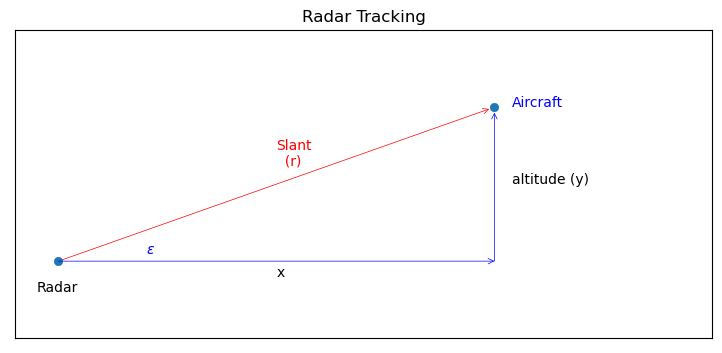

In [4]:
ekf_internal.show_radar_chart()

This gives us the equalities:

$$\begin{aligned}
\epsilon &= \tan^{-1} \frac y x\\
r^2 &= x^2 + y^2
\end{aligned}$$ 

### Design the State Variables

We want to track the position of an aircraft assuming a constant velocity and altitude, and measurements of the slant distance to the aircraft. That means we need 3 state variables - horizontal distance, horizontal velocity, and altitude:

$$\mathbf x = \begin{bmatrix}\mathtt{distance} \\\mathtt{velocity}\\ \mathtt{altitude}\end{bmatrix}=    \begin{bmatrix}x \\ \dot x\\ y\end{bmatrix}$$

### Design the Process Model

We assume a Newtonian, kinematic system for the aircraft. We've used this model in previous chapters, so by inspection you may recognize that we want

$$\mathbf F = \left[\begin{array}{cc|c} 1 & \Delta t & 0\\
0 & 1 & 0 \\ \hline
0 & 0 & 1\end{array}\right]$$

I've partioned the matrix into blocks to show the upper left block is a constant velocity model for $x$, and the lower right block is a constant position model for $y$.

However, let's practice finding these matrices. We model systems with a set of differential equations. We need an equation in the form 

$$\dot{\mathbf x} = \mathbf{Ax} + \mathbf{w}$$
where $\mathbf{w}$ is the system noise. 

The variables $x$ and $y$ are independent so we can compute them separately. The differential equations for motion in one dimension are:

$$\begin{aligned}v &= \dot x \\
a &= \ddot{x} = 0\end{aligned}$$

Now we put the differential equations into state-space form. If this was a second or greater order differential system we would have to first reduce them to an equivalent set of first degree equations. The equations are first order, so we put them in state space matrix form as

$$\begin{aligned}\begin{bmatrix}\dot x \\ \ddot{x}\end{bmatrix} &= \begin{bmatrix}0&1\\0&0\end{bmatrix} \begin{bmatrix}x \\ 
\dot x\end{bmatrix} \\ \dot{\mathbf x} &= \mathbf{Ax}\end{aligned}$$
where $\mathbf A=\begin{bmatrix}0&1\\0&0\end{bmatrix}$. 

Recall that $\mathbf A$ is the *system dynamics matrix*. It describes a set of linear differential equations. From it we must compute the state transition matrix $\mathbf F$. $\mathbf F$ describes a discrete set of linear equations which compute $\mathbf x$ for a discrete time step $\Delta t$.

A common way to compute $\mathbf F$ is to use the power series expansion of the matrix exponential:

$$\mathbf F(\Delta t) = e^{\mathbf A\Delta t} = \mathbf{I} + \mathbf A\Delta t  + \frac{(\mathbf A\Delta t)^2}{2!} + \frac{(\mathbf A \Delta t)^3}{3!} + ... $$


$\mathbf A^2 = \begin{bmatrix}0&0\\0&0\end{bmatrix}$, so all higher powers of $\mathbf A$ are also $\mathbf{0}$. Thus the power series expansion is:

$$
\begin{aligned}
\mathbf F &=\mathbf{I} + \mathbf At + \mathbf{0} \\
&= \begin{bmatrix}1&0\\0&1\end{bmatrix} + \begin{bmatrix}0&1\\0&0\end{bmatrix}\Delta t\\
\mathbf F &= \begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}
\end{aligned}$$

This is the same result used by the kinematic equations! This exercise was unnecessary other than to illustrate finding the state transition matrix from linear differential equations. We will conclude the chapter with an example that will require the use of this technique.

### Design the Measurement Model

The measurement function takes the state estimate of the prior $\bar{\mathbf x}$ and turn it into a measurement of the slant range distance. We use the Pythagorean theorem to derive:

$$h(\bar{\mathbf x}) = \sqrt{x^2 + y^2}$$

The relationship between the slant distance and the position on the ground is nonlinear due to the square root. We linearize it by evaluating its partial derivative at $\mathbf x_t$:

$$
\mathbf H = \frac{\partial{h(\bar{\mathbf x})}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t}
$$

The partial derivative of a matrix is called a Jacobian, and takes the form 

$$\frac{\partial \mathbf H}{\partial \bar{\mathbf x}} = 
\begin{bmatrix}
\frac{\partial h_1}{\partial x_1} & \frac{\partial h_1}{\partial x_2} &\dots \\
\frac{\partial h_2}{\partial x_1} & \frac{\partial h_2}{\partial x_2} &\dots \\
\vdots & \vdots
\end{bmatrix}
$$

In other words, each element in the matrix is the partial derivative of the function $h$ with respect to the $x$ variables. For our problem we have

$$\mathbf H = \begin{bmatrix}{\partial h}/{\partial x} & {\partial h}/{\partial \dot{x}} & {\partial h}/{\partial y}\end{bmatrix}$$

Solving each in turn:

$$\begin{aligned}
\frac{\partial h}{\partial x} &= \frac{\partial}{\partial x} \sqrt{x^2 + y^2} \\
&= \frac{x}{\sqrt{x^2 + y^2}}
\end{aligned}$$

and

$$\begin{aligned}
\frac{\partial h}{\partial \dot{x}} &=
\frac{\partial}{\partial \dot{x}} \sqrt{x^2 + y^2} \\ 
&= 0
\end{aligned}$$

and

$$\begin{aligned}
\frac{\partial h}{\partial y} &= \frac{\partial}{\partial y} \sqrt{x^2 + y^2} \\ 
&= \frac{y}{\sqrt{x^2 + y^2}}
\end{aligned}$$

giving us 

$$\mathbf H = 
\begin{bmatrix}
\frac{x}{\sqrt{x^2 + y^2}} & 
0 &
&
\frac{y}{\sqrt{x^2 + y^2}}
\end{bmatrix}$$

This may seem daunting, so step back and recognize that all of this math is doing something very simple. We have an equation for the slant range to the airplane which is nonlinear. The Kalman filter only works with linear equations, so we need to find a linear equation that approximates $\mathbf H$. As we discussed above, finding the slope of a nonlinear equation at a given point is a good approximation. For the Kalman filter, the 'given point' is the state variable $\mathbf x$ so we need to take the derivative of the slant range with respect to $\mathbf x$. For the linear Kalman filter $\mathbf H$ was a constant that we computed prior to running the filter. For the EKF $\mathbf H$ is updated at each step as the evaluation point $\bar{\mathbf x}$ changes at each epoch.

To make this more concrete, let's now write a Python function that computes the Jacobian of $h$ for this problem.

In [5]:
from math import sqrt
def HJacobian_at(x):
    """ compute Jacobian of H matrix at x """

    horiz_dist = x[0]
    altitude   = x[2]
    denom = sqrt(horiz_dist**2 + altitude**2)
    return array ([[horiz_dist/denom, 0., altitude/denom]])

Finally, let's provide the code for $h(\bar{\mathbf x})$:

In [6]:
def hx(x):
    """ compute measurement for slant range that
    would correspond to state x.
    """
    
    return (x[0]**2 + x[2]**2) ** 0.5

Now let's write a simulation for our radar.

In [7]:
from numpy.random import randn
import math

class RadarSim:
    """ Simulates the radar signal returns from an object
    flying at a constant altityude and velocity in 1D. 
    """
    
    def __init__(self, dt, pos, vel, alt):
        self.pos = pos
        self.vel = vel
        self.alt = alt
        self.dt = dt
        
    def get_range(self):
        """ Returns slant range to the object. Call once 
        for each new measurement at dt time from last call.
        """
        
        # add some process noise to the system
        self.vel = self.vel  + .1*randn()
        self.alt = self.alt + .1*randn()
        self.pos = self.pos + self.vel*self.dt
    
        # add measurement noise
        err = self.pos * 0.05*randn()
        slant_dist = math.sqrt(self.pos**2 + self.alt**2)
        
        return slant_dist + err

### Design Process and Measurement Noise

The radar measures the range to a target. We will use $\sigma_{range}= 5$ meters for the noise. This gives us

$$\mathbf R = \begin{bmatrix}\sigma_{range}^2\end{bmatrix} = \begin{bmatrix}25\end{bmatrix}$$


The design of $\mathbf Q$ requires some discussion. The state $\mathbf x= \begin{bmatrix}x & \dot x & y\end{bmatrix}^\mathtt{T}$. The first two elements are position (down range distance) and velocity, so we can use `Q_discrete_white_noise` noise to compute the values for the upper left hand side of $\mathbf Q$. The third element of  $\mathbf x$ is altitude, which we are assuming is independent of the down range distance. That leads us to a block design of $\mathbf Q$ of:

$$\mathbf Q = \begin{bmatrix}\mathbf Q_\mathtt{x} & 0 \\ 0 & \mathbf Q_\mathtt{y}\end{bmatrix}$$

### Implementation

`FilterPy` provides the class `ExtendedKalmanFilter`. It works similarly to the `KalmanFilter` class we have been using, except that it allows you to provide a function that computes the Jacobian of $\mathbf H$ and the function $h(\mathbf x)$. 

We start by importing the filter and creating it. The dimension of `x` is 3 and `z` has dimension 1.

```python
from filterpy.kalman import ExtendedKalmanFilter

rk = ExtendedKalmanFilter(dim_x=3, dim_z=1)
```
We create the radar simulator:
```python
radar = RadarSim(dt, pos=0., vel=100., alt=1000.)
```
We will initialize the filter near the airplane's actual position:

```python
rk.x = array([radar.pos, radar.vel-10, radar.alt+100])
```

We assign the system matrix using the first term of the Taylor series expansion we computed above:

```python
dt = 0.05
rk.F = eye(3) + array([[0, 1, 0],
                       [0, 0, 0],
                       [0, 0, 0]])*dt
```

After assigning reasonable values to $\mathbf R$, $\mathbf Q$, and $\mathbf P$ we can run the filter with a simple loop. We pass the functions for computing the Jacobian of $\mathbf  H$ and $h(x)$ into the `update` method.

```python
for i in range(int(20/dt)):
    z = radar.get_range()
    rk.update(array([z]), HJacobian_at, hx)
    rk.predict()
```

Adding some boilerplate code to save and plot the results we get:

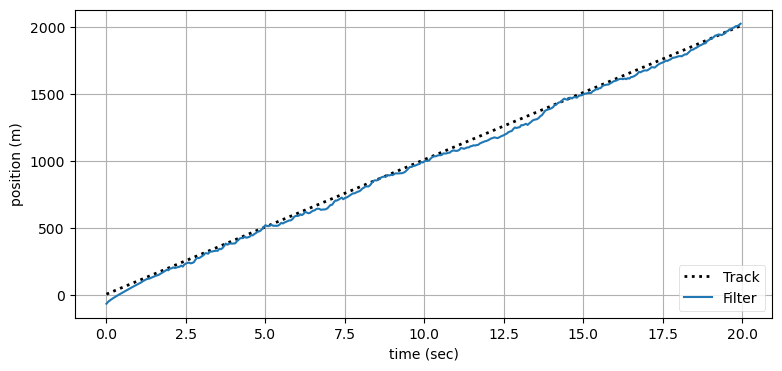

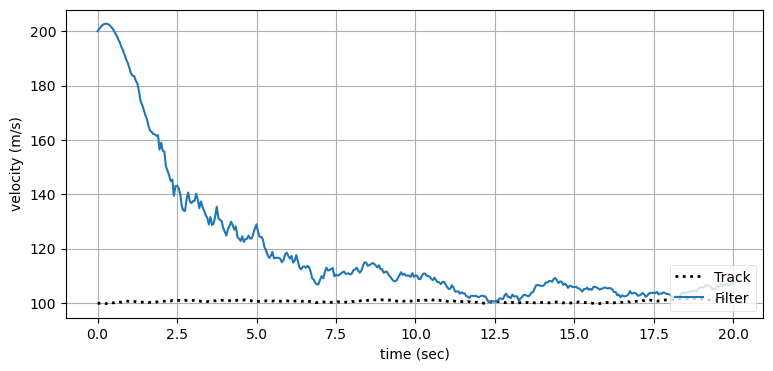

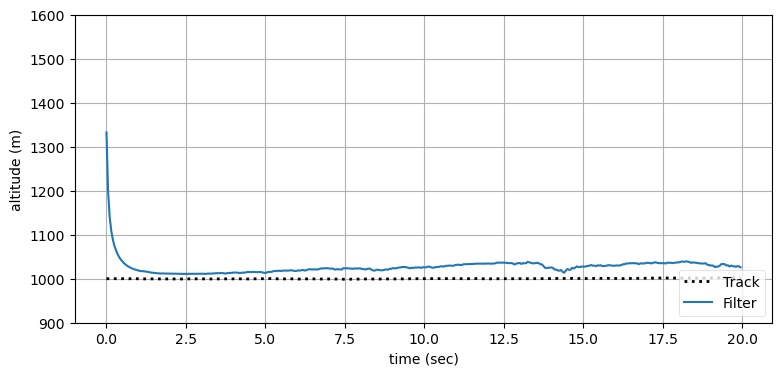

In [8]:
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import ExtendedKalmanFilter
from numpy import eye, array, asarray
import numpy as np

dt = 0.05
rk = ExtendedKalmanFilter(dim_x=3, dim_z=1)
radar = RadarSim(dt, pos=0., vel=100., alt=1000.)

# make an imperfect starting guess
rk.x = array([radar.pos-100, radar.vel+100, radar.alt+1000])

rk.F = eye(3) + array([[0, 1, 0],
                       [0, 0, 0],
                       [0, 0, 0]]) * dt

range_std = 5. # meters
rk.R = np.diag([range_std**2])
rk.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
rk.Q[2,2] = 0.1
rk.P *= 50

xs, track = [], []
for i in range(int(20/dt)):
    z = radar.get_range()
    track.append((radar.pos, radar.vel, radar.alt))
    
    rk.update(array([z]), HJacobian_at, hx)
    xs.append(rk.x)
    rk.predict()

xs = asarray(xs)
track = asarray(track)
time = np.arange(0, len(xs)*dt, dt)
ekf_internal.plot_radar(xs, track, time)

## Using SymPy to compute Jacobians

Depending on your experience with derivatives you may have found the computation of the Jacobian difficult. Even if you found it easy, a slightly more difficult problem easily leads to very difficult computations.

As explained in Appendix A, we can use the SymPy package to compute the Jacobian for us.

In [9]:
import sympy
from IPython.display import display
sympy.init_printing(use_latex='mathjax')

x, x_vel, y = sympy.symbols('x, x_vel y')

H = sympy.Matrix([sympy.sqrt(x**2 + y**2)])

state = sympy.Matrix([x, x_vel, y])
J = H.jacobian(state)

display(state)
display(J)

⎡ x  ⎤
⎢    ⎥
⎢xᵥₑₗ⎥
⎢    ⎥
⎣ y  ⎦

⎡     x                y      ⎤
⎢────────────  0  ────────────⎥
⎢   _________        _________⎥
⎢  ╱  2    2        ╱  2    2 ⎥
⎣╲╱  x  + y       ╲╱  x  + y  ⎦

This result is the same as the result we computed above, and with much less effort on our part!

## Robot Localization

It's time to try a real problem. I warn you that this section is difficult. However, most books choose simple, textbook problems with simple answers, and you are left wondering how to solve a real world problem. 

We will consider the problem of robot localization. We already implemented this in the **Unscented Kalman Filter** chapter, and I recommend you read it now if you haven't already.  In this scenario we have a robot that is moving through a landscape using a sensor to detect landmarks. This could be a self driving car using computer vision to identify trees, buildings, and other landmarks. It might be one of those small robots that vacuum your house, or a robot in a warehouse.

The robot has 4 wheels in the same configuration used by automobiles. It maneuvers by pivoting the front wheels. This causes the robot to pivot around the rear axle while moving forward. This is nonlinear behavior which we will have to model. 

The robot has a sensor that measures the range and bearing to known targets in the landscape. This is nonlinear because computing a position from a range and bearing requires square roots and trigonometry. 

Both the process model and measurement models are nonlinear. The EKF accommodates both, so we provisionally conclude that the EKF is a viable choice for this problem.

### Robot Motion Model

At a first approximation an automobile steers by pivoting the front tires while moving forward. The front of the car moves in the direction that the wheels are pointing while pivoting around the rear tires. This simple description is complicated by issues such as slippage due to friction, the differing behavior of the rubber tires at different speeds, and the need for the outside tire to travel a different radius than the inner tire. Accurately modeling steering requires a complicated set of differential equations. 

For lower speed robotic applications a simpler *bicycle model* has been found to perform well. This is a depiction of the model:

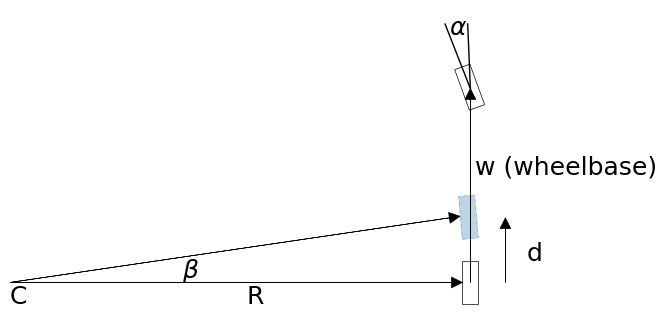

In [10]:
ekf_internal.plot_bicycle()

In the **Unscented Kalman Filter** chapter we derived these equations:

$$\begin{aligned} 
\beta &= \frac d w \tan(\alpha) \\
x &= x - R\sin(\theta) + R\sin(\theta + \beta) \\
y &= y + R\cos(\theta) - R\cos(\theta + \beta) \\
\theta &= \theta + \beta
\end{aligned}
$$

where $\theta$ is the robot's heading.

You do not need to understand this model in detail if you are not interested in steering models. The important thing to recognize is that our motion model is nonlinear, and we will need to deal with that with our Kalman filter.

### Design the State Variables

For our filter we will maintain the position $x,y$ and orientation $\theta$ of the robot:

$$\mathbf x = \begin{bmatrix}x \\ y \\ \theta\end{bmatrix}$$

Our control input $\mathbf u$ is the velocity $v$ and steering angle $\alpha$:

$$\mathbf u = \begin{bmatrix}v \\ \alpha\end{bmatrix}$$

### Design the System Model

We model our system as a nonlinear motion model plus noise.

$$\bar x = f(x, u) + \mathcal{N}(0, Q)$$



Using the motion model for a robot that we created above, we can expand this to

$$\bar{\begin{bmatrix}x\\y\\\theta\end{bmatrix}} = \begin{bmatrix}x\\y\\\theta\end{bmatrix} + 
\begin{bmatrix}- R\sin(\theta) + R\sin(\theta + \beta) \\
R\cos(\theta) - R\cos(\theta + \beta) \\
\beta\end{bmatrix}$$

We find The $\mathbf F$ by taking the Jacobian of $f(x,u)$.

$$\mathbf F = \frac{\partial f(x, u)}{\partial x} =\begin{bmatrix}
\frac{\partial f_1}{\partial x} & 
\frac{\partial f_1}{\partial y} &
\frac{\partial f_1}{\partial \theta}\\
\frac{\partial f_2}{\partial x} & 
\frac{\partial f_2}{\partial y} &
\frac{\partial f_2}{\partial \theta} \\
\frac{\partial f_3}{\partial x} & 
\frac{\partial f_3}{\partial y} &
\frac{\partial f_3}{\partial \theta}
\end{bmatrix}
$$

When we calculate these we get

$$\mathbf F = \begin{bmatrix}
1 & 0 & -R\cos(\theta) + R\cos(\theta+\beta) \\
0 & 1 & -R\sin(\theta) + R\sin(\theta+\beta) \\
0 & 0 & 1
\end{bmatrix}$$

We can double check our work with SymPy.

In [11]:
import sympy
from sympy.abc import alpha, x, y, v, w, R, theta
from sympy import symbols, Matrix
sympy.init_printing(use_latex="mathjax", fontsize='16pt')
time = symbols('t')
d = v*time
beta = (d/w)*sympy.tan(alpha)
r = w/sympy.tan(alpha)

fxu = Matrix([[x-r*sympy.sin(theta) + r*sympy.sin(theta+beta)],
              [y+r*sympy.cos(theta)- r*sympy.cos(theta+beta)],
              [theta+beta]])
F = fxu.jacobian(Matrix([x, y, theta]))
F

⎡                        ⎛t⋅v⋅tan(α)    ⎞⎤
⎢                   w⋅cos⎜────────── + θ⎟⎥
⎢        w⋅cos(θ)        ⎝    w         ⎠⎥
⎢1  0  - ──────── + ─────────────────────⎥
⎢         tan(α)            tan(α)       ⎥
⎢                                        ⎥
⎢                        ⎛t⋅v⋅tan(α)    ⎞⎥
⎢                   w⋅sin⎜────────── + θ⎟⎥
⎢        w⋅sin(θ)        ⎝    w         ⎠⎥
⎢0  1  - ──────── + ─────────────────────⎥
⎢         tan(α)            tan(α)       ⎥
⎢                                        ⎥
⎣0  0                  1                 ⎦

That looks a bit complicated. We can use SymPy to substitute terms:

In [12]:
# reduce common expressions
B, R = symbols('beta, R')
F = F.subs((d/w)*sympy.tan(alpha), B)
F.subs(w/sympy.tan(alpha), R)

⎡1  0  -R⋅cos(θ) + R⋅cos(β + θ)⎤
⎢                              ⎥
⎢0  1  -R⋅sin(θ) + R⋅sin(β + θ)⎥
⎢                              ⎥
⎣0  0             1            ⎦

This form  verifies that the computation of the Jacobian is correct.

Now we can turn our attention to the noise. Here, the noise is in our control input, so it is in *control space*. In other words, we command a specific velocity and steering angle, but we need to convert that into errors in $x, y, \theta$. In a real system this might vary depending on velocity, so it will need to be recomputed for every prediction. I will choose this as the noise model; for a real robot you will need to choose a model that accurately depicts the error in your system. 

$$\mathbf{M} = \begin{bmatrix}\sigma_{vel}^2 & 0 \\ 0 & \sigma_\alpha^2\end{bmatrix}$$

If this was a linear problem we would convert from control space to state space using the by now familiar $\mathbf{FMF}^\mathsf T$ form. Since our motion model is nonlinear we do not try to find a closed form solution to this, but instead linearize it with a Jacobian which we will name $\mathbf{V}$. 

$$\mathbf{V} = \frac{\partial f(x, u)}{\partial u} \begin{bmatrix}
\frac{\partial f_1}{\partial v} & \frac{\partial f_1}{\partial \alpha} \\
\frac{\partial f_2}{\partial v} & \frac{\partial f_2}{\partial \alpha} \\
\frac{\partial f_3}{\partial v} & \frac{\partial f_3}{\partial \alpha}
\end{bmatrix}$$

These partial derivatives become very difficult to work with. Let's compute them with SymPy. 

In [13]:
V = fxu.jacobian(Matrix([v, alpha]))
V = V.subs(sympy.tan(alpha)/w, 1/R) 
V = V.subs(time*v/R, B)
V = V.subs(time*v, 'd')
V

⎡                ⎛   2       ⎞                ⎛     2       ⎞            ⎛    
⎢              d⋅⎝tan (α) + 1⎠⋅cos(β + θ)   w⋅⎝- tan (α) - 1⎠⋅sin(θ)   w⋅⎝- ta
⎢t⋅cos(β + θ)  ────────────────────────── - ──────────────────────── + ───────
⎢                        tan(α)                        2                      
⎢                                                   tan (α)                   
⎢                                                                             
⎢                ⎛   2       ⎞                ⎛     2       ⎞            ⎛    
⎢              d⋅⎝tan (α) + 1⎠⋅sin(β + θ)   w⋅⎝- tan (α) - 1⎠⋅cos(θ)   w⋅⎝- ta
⎢t⋅sin(β + θ)  ────────────────────────── + ──────────────────────── - ───────
⎢                        tan(α)                        2                      
⎢                                                   tan (α)                   
⎢                                                                             
⎢                                                  ⎛

This should give you an appreciation of how quickly the EKF become mathematically intractable. 

This gives us the final form of our prediction equations:

$$\begin{aligned}
\mathbf{\bar x} &= \mathbf x + 
\begin{bmatrix}- R\sin(\theta) + R\sin(\theta + \beta) \\
R\cos(\theta) - R\cos(\theta + \beta) \\
\beta\end{bmatrix}\\
\mathbf{\bar P} &=\mathbf{FPF}^{\mathsf T} + \mathbf{VMV}^{\mathsf T}
\end{aligned}$$

This form of linearization is not the only way to predict $\mathbf x$. For example, we could use a numerical integration technique such as *Runge Kutta* to compute the movement
of the robot. This will be required if the time step is relatively large. Things are not as cut and dried with the EKF as for the Kalman filter. For a real problem you have to carefully model your system with differential equations and then determine the most appropriate way to solve that system. The correct approach depends on the accuracy you require, how nonlinear the equations are, your processor budget, and numerical stability concerns.

### Design the Measurement Model

The robot's sensor provides a noisy bearing and range measurement to multiple known locations in the landscape. The measurement model must convert the state $\begin{bmatrix}x & y&\theta\end{bmatrix}^\mathsf T$ into a range and bearing to the landmark. If $\mathbf p$ 
is the position of a landmark, the range $r$ is

$$r = \sqrt{(p_x - x)^2 + (p_y - y)^2}$$

The sensor provides bearing relative to the orientation of the robot, so we must subtract the robot's orientation from the bearing to get the sensor reading, like so:

$$\phi = \arctan(\frac{p_y - y}{p_x - x}) - \theta$$


Thus our measurement model $h$ is


$$\begin{aligned}
\mathbf z& = h(\bar{\mathbf x}, \mathbf p) &+ \mathcal{N}(0, R)\\
&= \begin{bmatrix}
\sqrt{(p_x - x)^2 + (p_y - y)^2} \\
\arctan(\frac{p_y - y}{p_x - x}) - \theta 
\end{bmatrix} &+ \mathcal{N}(0, R)
\end{aligned}$$

This is clearly nonlinear, so we need linearize $h$  at $\mathbf x$ by taking its Jacobian. We compute that with SymPy below.

In [14]:
px, py = symbols('p_x, p_y')
z = Matrix([[sympy.sqrt((px-x)**2 + (py-y)**2)],
            [sympy.atan2(py-y, px-x) - theta]])
z.jacobian(Matrix([x, y, theta]))

⎡          -pₓ + x                      -p_y + y             ⎤
⎢───────────────────────────  ───────────────────────────  0 ⎥
⎢   ________________________     ________________________    ⎥
⎢  ╱         2            2     ╱         2            2     ⎥
⎢╲╱  (pₓ - x)  + (p_y - y)    ╲╱  (pₓ - x)  + (p_y - y)      ⎥
⎢                                                            ⎥
⎢       -(-p_y + y)                   -(pₓ - x)              ⎥
⎢  ──────────────────────       ──────────────────────     -1⎥
⎢          2            2               2            2       ⎥
⎣  (pₓ - x)  + (p_y - y)        (pₓ - x)  + (p_y - y)        ⎦

Now we need to write that as a Python function. For example we might write:

In [15]:
from math import sqrt

def H_of(x, landmark_pos):
    """ compute Jacobian of H matrix where h(x) computes 
    the range and bearing to a landmark for state x """

    px = landmark_pos[0]
    py = landmark_pos[1]
    hyp = (px - x[0, 0])**2 + (py - x[1, 0])**2
    dist = sqrt(hyp)

    H = array(
        [[-(px - x[0, 0]) / dist, -(py - x[1, 0]) / dist, 0],
         [ (py - x[1, 0]) / hyp,  -(px - x[0, 0]) / hyp, -1]])
    return H

We also need to define a function that converts the system state into a measurement.

In [16]:
from math import atan2

def Hx(x, landmark_pos):
    """ takes a state variable and returns the measurement
    that would correspond to that state.
    """
    px = landmark_pos[0]
    py = landmark_pos[1]
    dist = sqrt((px - x[0, 0])**2 + (py - x[1, 0])**2)

    Hx = array([[dist],
                [atan2(py - x[1, 0], px - x[0, 0]) - x[2, 0]]])
    return Hx

### Design Measurement Noise

It is reasonable to assume that the noise of the range and bearing measurements are independent, hence

$$\mathbf R=\begin{bmatrix}\sigma_{range}^2 & 0 \\ 0 & \sigma_{bearing}^2\end{bmatrix}$$

### Implementation

We will use `FilterPy`'s `ExtendedKalmanFilter` class to implement the filter. Its `predict()` method uses the standard linear equations for the process model. Ours is nonlinear, so we will have to override `predict()` with our own implementation.  I'll want to also use this class to simulate the robot, so I'll add a method `move()` that computes the position of the robot which both `predict()` and my simulation can call.

The matrices for the prediction step are quite large. While writing this code I made several errors before I finally got it working. I only found my errors by using SymPy's `evalf` function. `evalf` evaluates a SymPy `Matrix` with specific values for the variables. I decided to demonstrate this technique to you, and used `evalf` in the Kalman filter code. You'll need to understand a couple of points.

First, `evalf` uses a dictionary to specify the values. For example, if your matrix contains an `x` and `y`, you can write

```python
    M.evalf(subs={x:3, y:17})
```
    
to evaluate the matrix for `x=3` and `y=17`. 

Second, `evalf` returns a `sympy.Matrix` object. Use `numpy.array(M).astype(float)` to convert it to a NumPy array. `numpy.array(M)` creates an array of  type `object`, which is not what you want.

Here is the code for the EKF:

In [17]:
from filterpy.kalman import ExtendedKalmanFilter as EKF
from numpy import array, sqrt
class RobotEKF(EKF):
    def __init__(self, dt, wheelbase, std_vel, std_steer):
        EKF.__init__(self, 3, 2, 2)
        self.dt = dt
        self.wheelbase = wheelbase
        self.std_vel = std_vel
        self.std_steer = std_steer

        a, x, y, v, w, theta, time = symbols(
            'a, x, y, v, w, theta, t')
        d = v*time
        beta = (d/w)*sympy.tan(a)
        r = w/sympy.tan(a)
    
        self.fxu = Matrix(
            [[x-r*sympy.sin(theta)+r*sympy.sin(theta+beta)],
             [y+r*sympy.cos(theta)-r*sympy.cos(theta+beta)],
             [theta+beta]])

        self.F_j = self.fxu.jacobian(Matrix([x, y, theta]))
        self.V_j = self.fxu.jacobian(Matrix([v, a]))

        # save dictionary and it's variables for later use
        self.subs = {x: 0, y: 0, v:0, a:0, 
                     time:dt, w:wheelbase, theta:0}
        self.x_x, self.x_y, = x, y 
        self.v, self.a, self.theta = v, a, theta

    def predict(self, u):
        self.x = self.move(self.x, u, self.dt)
        self.subs[self.x_x] = self.x[0, 0]
        self.subs[self.x_y] = self.x[1, 0]

        self.subs[self.theta] = self.x[2, 0]
        self.subs[self.v] = u[0]
        self.subs[self.a] = u[1]

        F = array(self.F_j.evalf(subs=self.subs)).astype(float)
        V = array(self.V_j.evalf(subs=self.subs)).astype(float)

        # covariance of motion noise in control space
        M = array([[self.std_vel**2, 0], 
                   [0, self.std_steer**2]])

        self.P = F @ self.P @ F.T + V @ M @ V.T

    def move(self, x, u, dt):
        hdg = x[2, 0]
        vel = u[0]
        steering_angle = u[1]
        dist = vel * dt

        if abs(steering_angle) > 0.001: # is robot turning?
            beta = (dist / self.wheelbase) * tan(steering_angle)
            r = self.wheelbase / tan(steering_angle) # radius

            dx = np.array([[-r*sin(hdg) + r*sin(hdg + beta)], 
                           [r*cos(hdg) - r*cos(hdg + beta)], 
                           [beta]])
        else: # moving in straight line
            dx = np.array([[dist*cos(hdg)], 
                           [dist*sin(hdg)], 
                           [0]])
        return x + dx

Now we have another issue to handle. The residual is notionally computed as $y = z - h(x)$ but this will not work because our measurement contains an angle in it. Suppose z has a bearing of $1^\circ$ and $h(x)$ has a bearing of $359^\circ$. Naively subtracting them would yield a angular difference of $-358^\circ$, whereas the correct value is $2^\circ$. We have to write code to correctly compute the bearing residual.

In [18]:
def residual(a, b):
    """ compute residual (a-b) between measurements containing 
    [range, bearing]. Bearing is normalized to [-pi, pi)"""
    y = a - b
    y[1] = y[1] % (2 * np.pi)    # force in range [0, 2 pi)
    if y[1] > np.pi:             # move to [-pi, pi)
        y[1] -= 2 * np.pi
    return y

The rest of the code runs the simulation and plots the results, and shouldn't need too much comment by now. I create a variable `landmarks` that contains the landmark coordinates. I update the simulated robot position 10 times a second, but run the EKF only once per second. This is for two reasons. First, we are not using Runge Kutta to integrate the differental equations of motion, so a narrow time step allows our simulation to be more accurate. Second, it is fairly normal in embedded systems to have limited processing speed. This forces you to run your Kalman filter only as frequently as absolutely needed.

In [19]:
from filterpy.stats import plot_covariance_ellipse
from math import sqrt, tan, cos, sin, atan2
import matplotlib.pyplot as plt

dt = 1.0

def z_landmark(lmark, sim_pos, std_rng, std_brg):
    x, y = sim_pos[0, 0], sim_pos[1, 0]
    d = np.sqrt((lmark[0] - x)**2 + (lmark[1] - y)**2)  
    a = atan2(lmark[1] - y, lmark[0] - x) - sim_pos[2, 0]
    z = np.array([[d + randn()*std_rng],
                  [a + randn()*std_brg]])
    return z

def ekf_update(ekf, z, landmark):
    ekf.update(z, HJacobian=H_of, Hx=Hx, 
               residual=residual,
               args=(landmark), hx_args=(landmark))
    
                
def run_localization(landmarks, std_vel, std_steer, 
                     std_range, std_bearing,
                     step=10, ellipse_step=20, ylim=None):
    ekf = RobotEKF(dt, wheelbase=0.5, std_vel=std_vel, 
                   std_steer=std_steer)
    ekf.x = array([[2, 6, .3]]).T # x, y, steer angle
    ekf.P = np.diag([.1, .1, .1])
    ekf.R = np.diag([std_range**2, std_bearing**2])

    sim_pos = ekf.x.copy() # simulated position
    # steering command (vel, steering angle radians)
    u = array([1.1, .01]) 

    plt.figure()
    plt.scatter(landmarks[:, 0], landmarks[:, 1],
                marker='s', s=60)
    
    track = []
    for i in range(200):
        sim_pos = ekf.move(sim_pos, u, dt/10.) # simulate robot
        track.append(sim_pos)

        if i % step == 0:
            ekf.predict(u=u)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ekf.x[0,0], ekf.x[1,0]), ekf.P[0:2, 0:2], 
                     std=6, facecolor='k', alpha=0.3)

            x, y = sim_pos[0, 0], sim_pos[1, 0]
            for lmark in landmarks:
                z = z_landmark(lmark, sim_pos,
                               std_range, std_bearing)
                ekf_update(ekf, z, lmark)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ekf.x[0,0], ekf.x[1,0]), ekf.P[0:2, 0:2],
                    std=6, facecolor='g', alpha=0.8)
    track = np.array(track)
    plt.plot(track[:, 0], track[:,1], color='k', lw=2)
    plt.axis('equal')
    plt.title("EKF Robot localization")
    if ylim is not None: plt.ylim(*ylim)
    plt.show()
    return ekf

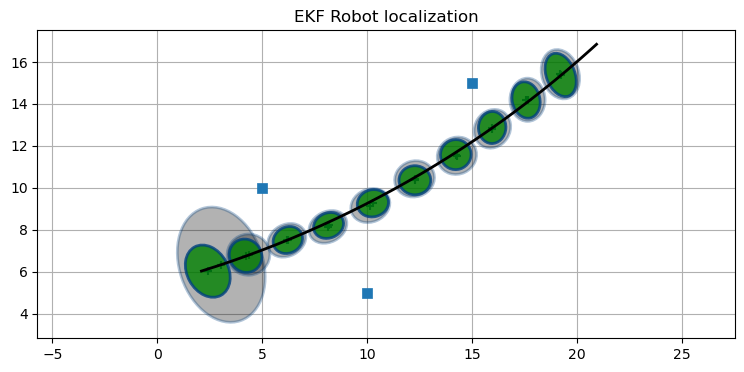

Final P: [0.017 0.035 0.002]


In [20]:
landmarks = array([[5, 10], [10, 5], [15, 15]])

ekf = run_localization(
    landmarks, std_vel=0.1, std_steer=np.radians(1),
    std_range=0.3, std_bearing=0.1)
print('Final P:', ekf.P.diagonal())

I have plotted the landmarks as solid squares. The path of the robot is drawn with a black line. The covariance ellipses for the predict step are light gray, and the covariances of the update are shown in green. To make them visible at this scale I have set the ellipse boundary at 6$\sigma$.

We can see that there is a lot of uncertainty added by our motion model, and that most of the error in in the direction of motion. We determine that from the shape of the blue ellipses. After a few steps we can see that the filter incorporates the landmark measurements and the errors improve.

I used the same initial conditions and landmark locations in the UKF chapter. The UKF achieves much better accuracy in terms of the error ellipse. Both perform roughly as well as far as their estimate for $\mathbf x$ is concerned. 

Now let's add another landmark.

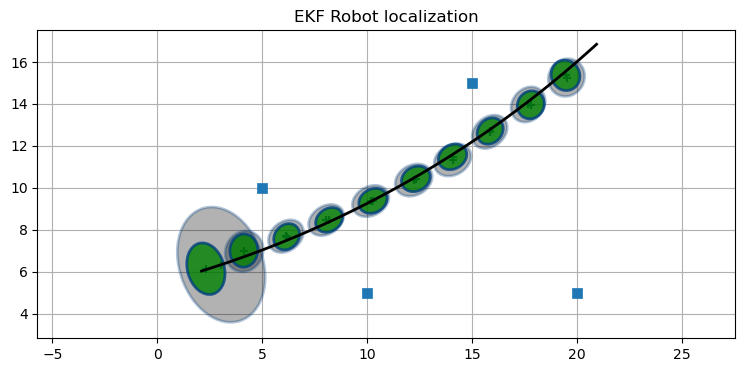

Final P: [0.014 0.016 0.002]


In [21]:
landmarks = array([[5, 10], [10, 5], [15, 15], [20, 5]])

ekf = run_localization(
    landmarks, std_vel=0.1, std_steer=np.radians(1),
    std_range=0.3, std_bearing=0.1)
plt.show()
print('Final P:', ekf.P.diagonal())

The uncertainly in the estimates near the end of the track are smaller.  We can see the effect that multiple landmarks have on our uncertainty by only using the first two landmarks.

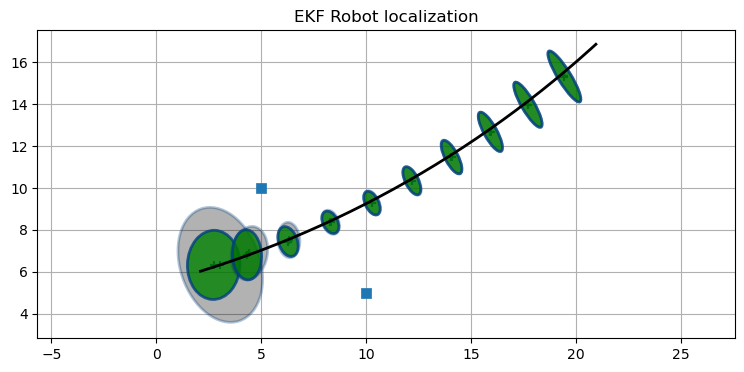

Final P: [0.02  0.046 0.   ]


In [22]:
ekf = run_localization(
    landmarks[0:2], std_vel=1.e-10, std_steer=1.e-10,
    std_range=1.4, std_bearing=.05)
print('Final P:', ekf.P.diagonal())

The estimate quickly diverges from the robot's path after passing the landmarks. The covariance also grows quickly. Let's see what happens with only one landmark:

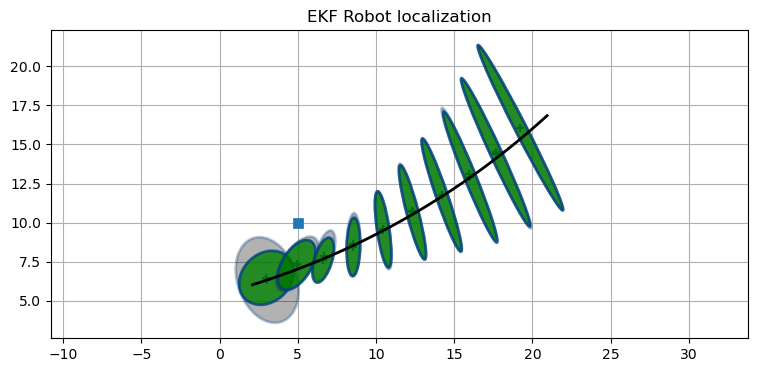

Final P: [0.249 0.849 0.004]


In [23]:
ekf = run_localization(
    landmarks[0:1], std_vel=1.e-10, std_steer=1.e-10,
    std_range=1.4, std_bearing=.05)
print('Final P:', ekf.P.diagonal())

As you probably suspected, one landmark produces a very bad result. Conversely, a large number of landmarks allows us to make very accurate estimates.

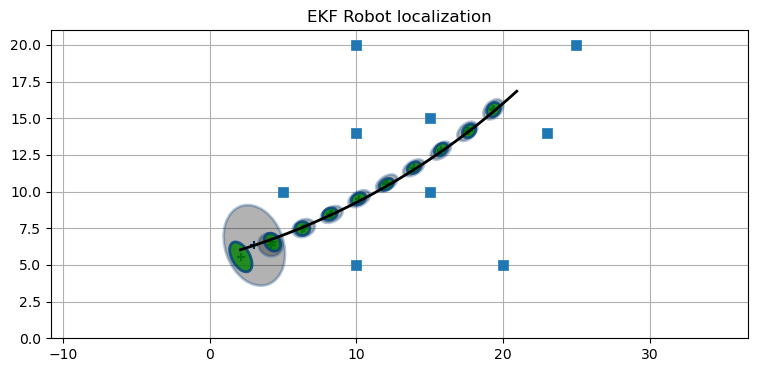

Final P: [0.006 0.007 0.001]


In [24]:
landmarks = array([[5, 10], [10,  5], [15, 15], [20,  5], [15, 10], 
                   [10,14], [23, 14], [25, 20], [10, 20]])

ekf = run_localization(
    landmarks, std_vel=0.1, std_steer=np.radians(1),
    std_range=0.3, std_bearing=0.1, ylim=(0, 21))
print('Final P:', ekf.P.diagonal())

### Discussion

I said that this was a real problem, and in some ways it is. I've seen alternative presentations that used robot motion models that led to simpler Jacobians. On the other hand, my model of the movement is also simplistic in several ways. First, it uses a bicycle model. A real car has two sets of tires, and each travels on a different radius. The wheels do not grip the surface perfectly. I also assumed that the robot responds instantaneously to the control input. Sebastian Thrun writes in *Probabilistic Robots* that this simplified model is justified because the filters perform well when used to track real vehicles. The lesson here is that while you have to have a reasonably accurate nonlinear model, it does not need to be perfect to operate well. As a designer you will need to balance the fidelity of your model with the difficulty of the math and the CPU time required to perform the linear algebra. 

Another way in which this problem was simplistic is that we assumed that we knew the correspondance between the landmarks and measurements. But suppose we are using radar - how would we know that a specific signal return corresponded to a specific building in the local scene? This question hints at SLAM algorithms - simultaneous localization and mapping. SLAM is not the point of this book, so I will not elaborate on this topic. 

## UKF vs EKF


In the last chapter I used the UKF to solve this problem. The difference in implementation should be very clear. Computing the Jacobians for the state and measurement models was not trivial despite a rudimentary motion model. A different problem could result in a Jacobian which is difficult or impossible to derive analytically. In contrast, the UKF only requires you to provide a function that computes the system motion model and another for the measurement model. 

There are many cases where the Jacobian cannot be found analytically. The details are beyond the scope of this book, but you will have to use numerical methods to compute the Jacobian. That undertaking is not trivial, and you will spend a significant portion of a master's degree at a STEM school learning techniques to handle such situations. Even then you'll likely only be able to solve problems related to your field - an aeronautical engineer learns a lot about Navier Stokes equations, but not much about modelling chemical reaction rates. 

So, UKFs are easy. Are they accurate? In practice they often perform better than the EKF. You can find plenty of research papers that prove that the UKF outperforms the EKF in various problem domains. It's not hard to understand why this would be true. The EKF works by linearizing the system model and measurement model at a single point, and the UKF uses $2n+1$ points.

Let's look at a specific example. Take $f(x) = x^3$ and pass a Gaussian distribution through it. I will compute an accurate answer using a monte carlo simulation. I generate 50,000 points randomly distributed according to the Gaussian, pass each through $f(x)$, then compute the mean and variance of the result. 

The EKF linearizes the function by taking the derivative to find the slope at the evaluation point $x$. This slope becomes the linear function that we use to transform the Gaussian. Here is a plot of that.

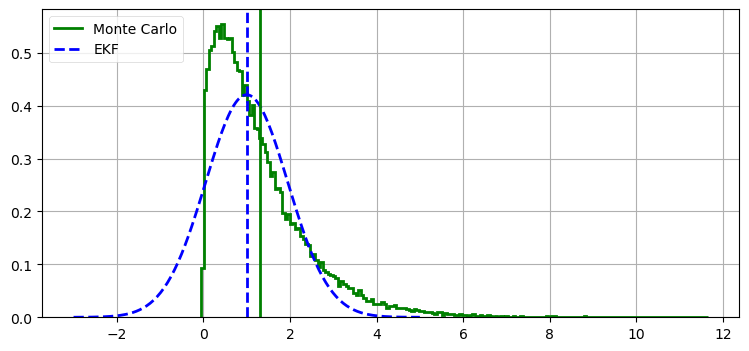

actual mean=1.30, std=1.12
EKF    mean=1.00, std=0.95


In [25]:
import kf_book.nonlinear_plots as nonlinear_plots
nonlinear_plots.plot_ekf_vs_mc()

The EKF computation is rather inaccurate. In contrast, here is the performance of the UKF:

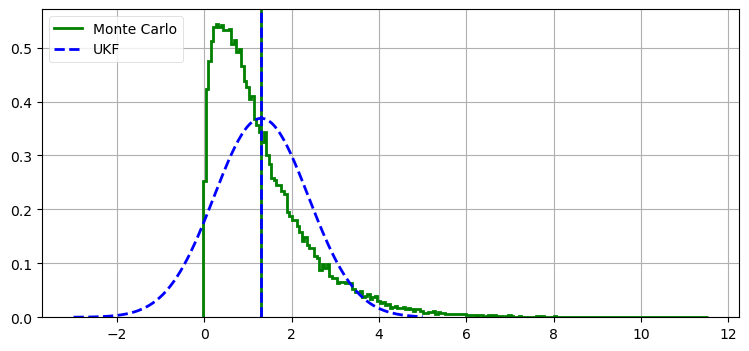

actual mean=1.30, std=1.13
UKF    mean=1.30, std=1.08


In [26]:
nonlinear_plots.plot_ukf_vs_mc(alpha=0.001, beta=3., kappa=1.)

Here we can see that the computation of the UKF's mean is accurate to 2 decimal places. The standard deviation is slightly off, but you can also fine tune how the UKF computes the distribution by using the $\alpha$, $\beta$, and $\gamma$ parameters for generating the sigma points. Here I used $\alpha=0.001$, $\beta=3$, and $\gamma=1$. Feel free to modify them to see the result. You should be able to get better results than I did. However, avoid over-tuning the UKF for a specific test. It may perform better for your test case, but worse in general.